# Comparison of ED and CTHYB

for an Hubbard atom hybridized with two non-interacting levels<br>

$$ H = 
U \hat{n}_{0\uparrow} \hat{n}_{0\downarrow} - \mu (\hat{n}_{0\uparrow} + \hat{n}_{0\downarrow})
$$
$$+ \sum_{\sigma=\uparrow,\downarrow} \Big[
V_1 (c^\dagger_{0,\sigma} c_{1,\sigma} + \text{h.c} ) +
V_2 (c^\dagger_{0,\sigma} c_{2,\sigma} + \text{h.c} ) +
\epsilon_1 \hat{n}_{1,\sigma} + \epsilon_2 \hat{n}_{2,\sigma}
\Big]
$$

In [47]:
import copy
import itertools
import numpy as np

from pytriqs.gf import *
from pytriqs.archive import *
from pytriqs.operators import *
from pytriqs.statistics.histogram import *

import matplotlib.pyplot as plt
from pytriqs.plot.mpl_interface import *

# -- Load data from hdf5 files

class Dummy():
     def __init__(self):
        pass
    
ed = Dummy()
pom = Dummy()
cthyb = Dummy()
    
input_data = [
    (ed, 'data_ed.h5'), 
    (cthyb, 'data_cthyb.h5'),
    (pom, 'data_pomerol.h5')]

for d, filename in input_data:
    print '--> Loading:', filename
    with HDFArchive(filename, 'r') as h5:
        for key, value in h5.items():
            setattr(d, key, value)                
    d.filename = filename

--> Loading: data_ed.h5
--> Loading: data_cthyb.h5
--> Loading: data_pomerol.h5


# Compare parameters between calculations

In [48]:
# -- Compare system parameters
ed_set = set(ed.params.keys())
cthyb_set = set(cthyb.params.keys())
common = ed_set.intersection(cthyb_set)

print '\n%10s | %7s | %7s | %7s' % ('parameter', 'ed', 'cthyb', 'pomerol')
print '-'*11 + '+' + '-'*9 + '+' + '-'*9 + '+' + '-'*10
for key in sorted(list(common)):
    ed_val = ed.params[key]
    cthyb_val = cthyb.params[key]
    pom_val = pom.params[key]
    
    print '%10s | %7s | %7s | %7s' % (key, ed_val, cthyb_val, pom_val)
    assert( ed_val == cthyb_val )
    assert( ed_val == pom_val )
    
print '\n ok!'


 parameter |      ed |   cthyb | pomerol
-----------+---------+---------+----------
         U |       5 |     5.0 |     5.0
        V1 |     2.0 |     2.0 |     2.0
        V2 |     5.0 |     5.0 |     5.0
      beta |     2.0 |     2.0 |     2.0
  epsilon1 |     0.0 |     0.0 |     0.0
  epsilon2 |     4.0 |     4.0 |     4.0
        mu |     2.0 |     2.0 |     2.0

 ok!


# Compare single-particle Green's functions

data_cthyb.h5 - data_ed.h5 Max(Abs(diff)) = 0.00681075380074


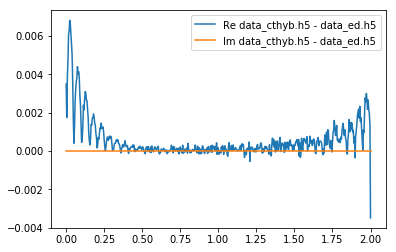

data_pomerol.h5 - data_ed.h5 Max(Abs(diff)) = 6.014959264e-08


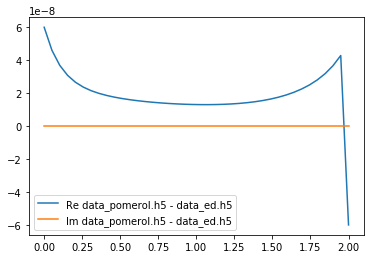

In [49]:
def plot_g_tau(d):
    oplot(d.G_tau, label=d.filename)
    plt.show()

def plot_g_tau_diff(d1, d2, tol=1e-9):
    tau = np.array([t for t in d1.G_tau.mesh])
    diff = np.zeros_like(tau, dtype=np.complex)
    
    for idx, t in enumerate(tau):
        diff[idx] = d1.G_tau(t) - d2.G_tau(t)
                
    label = d1.filename + ' - ' + d2.filename
    
    print label, 'Max(Abs(diff)) =', np.max(np.abs(diff))
    assert( (np.abs(diff) < tol).all() )
    
    plt.plot(tau, diff.real, label='Re ' + label)
    plt.plot(tau, diff.imag, label='Im ' + label)
    plt.legend(loc='best')
    plt.show()

#plot_g_tau(ed)
#plot_g_tau(pom)
#plot_g_tau(cthyb)

plot_g_tau_diff(cthyb, ed, tol=7e-3)
plot_g_tau_diff(pom, ed, tol=1e-7)

# Compare two-particle Green's functions

In imaginary time

$$ 
G_{\bar{a}b \bar{c}d}(\tau_1, \tau_2, \tau_3) \equiv 
- \langle 
c^\dagger_{\bar{a}}(\tau_1) c_{b}(\tau_2) 
c^\dagger_{\bar{c}}(\tau_3) c_{d}(0) 
\rangle
$$

and Matsubara frequency

$$
G_{\bar{a}b \bar{c}d}(i\nu_1, i\nu_2, i\nu_3) \equiv 
- \langle 
c^\dagger_{\bar{a}}(i\nu_1) c_{b}(i\nu_2) 
c^\dagger_{\bar{c}}(i\nu_3) c_{d}(i\nu_4) 
\rangle \Big|_{\nu_1 + \nu_3 = \nu_2 + \nu_4}
$$

NB! Exact results in the two different representations are obtained from two different ED codes. Imaginary time from `pyed` and matsubara frequency from `pomerol`.

In [74]:
def plot_G2_iw(d, w1=20, opt={}):
    
    g4_iw = d.G2_iw
    filename = d.filename

    plt.figure(figsize=(3.25*2, 3))
    subp = [1, 2, 1]

    plt.subplot(*subp); subp[-1] += 1
    plt.title(d.filename + ' Re[G]')
    plt.pcolormesh( g4_iw.data[w1,:,:,0,0,0,0].real, **opt )
    plt.colorbar()
    plt.axis('equal')

    plt.subplot(*subp); subp[-1] += 1
    plt.title(d.filename + ' Im[G]')
    plt.pcolormesh( g4_iw.data[w1,:,:,0,0,0,0].imag, **opt )
    plt.colorbar()
    plt.axis('equal')
    
    plt.tight_layout()
    
def plot_G2_tau(G2_tau, filename, t1=15, opt={}):

    #g4_tau = d.G2_tau
    g4_tau = G2_tau
    #filename = d.filename
    
    plt.figure(figsize=(3.25, 3))
    plt.title(filename)
    plt.pcolormesh( g4_tau.data[t1,:,:,0,0,0,0].real, **opt )
    plt.colorbar()
    plt.axis('equal')

    plt.tight_layout()
    

# Two frequency slice

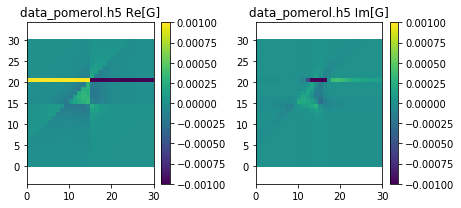

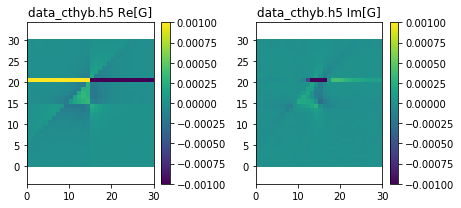

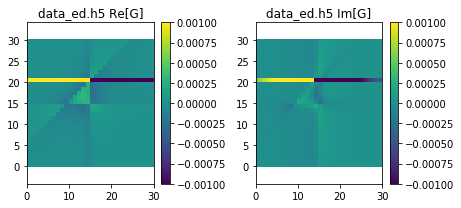

In [64]:
opt = dict(vmin=-0.001, vmax=0.001)
plot_G2_iw(pom, opt=opt)
plot_G2_iw(cthyb, opt=opt)
plot_G2_iw(ed, opt=opt)
plt.show()

## Compare CTHYB with Pomerol in Matsubara frequency

Max(Abs(diff)) = 1.98822854743e-05


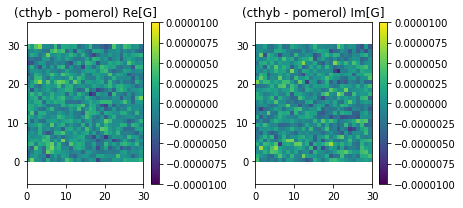

In [65]:
diff = copy.deepcopy(cthyb)
diff.G2_iw.data[:] -= pom.G2_iw.data

max_abs_diff = np.max(np.abs(diff.G2_iw.data))
print 'Max(Abs(diff)) =', max_abs_diff

assert( max_abs_diff < 1e-4 )

diff.filename = '(cthyb - pomerol)'
opt = dict(vmin=-0.00001, vmax=0.00001)
plot_G2_iw(diff, opt=opt)
plt.show()

Compare the fourier transformed result from `pyed` with the exact result from `pomerol`. This will never converge since we are using direct discrete Fourier transform, but is a good sanity check.

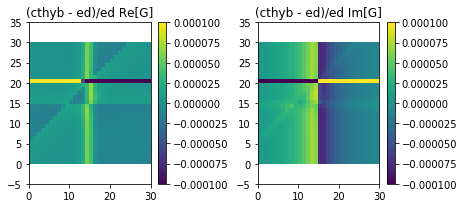

In [98]:
diff = copy.deepcopy(pom)
diff.G2_iw.data[:] -= ed.G2_iw.data
#diff.G2_iw.data[:] /= ed.G2_iw.data

diff.filename = '(cthyb - ed)/ed'
opt = dict(vmin=-0.0001, vmax=0.0001)
plot_G2_iw(diff, opt=opt)
plt.show()

## Imaginary time slice

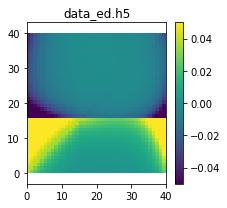

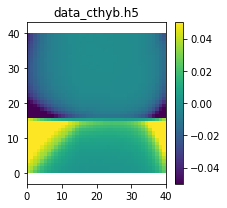

In [99]:
opt = dict(vmin=-0.05, vmax=0.05)
plot_G2_tau(ed.G2_tau, ed.filename, opt=opt)
plot_G2_tau(cthyb.G2_tau, cthyb.filename, opt=opt)
plt.show()

## Compare CTHYB with PYED in imaginary time

The imaginary time binning can not get the equal time points correctly in the standard implementation.

To asses the error away from the equal time planes, we setup some tools for setting these planes to zero.

In [100]:
def enumerate_tau3(g4_tau, make_real=True, beta=None):

    from pytriqs.gf import MeshImTime, MeshProduct
    
    assert( type(g4_tau.mesh) == MeshProduct )

    for mesh in g4_tau.mesh.components:
        assert( type(mesh) == MeshImTime )
        if beta is not None: assert( mesh.beta == beta )

    for (i1, t1), (i2, t2), (i3, t3) in itertools.product(*[
            enumerate(mesh) for mesh in g4_tau.mesh.components]):
        if make_real:
            yield (i1, i2, i3), (t1.real, t2.real, t3.real)
        else:
            yield (i1, i2, i3), (t1, t2, t3)

In [101]:
def zero_outer_planes_and_equal_times(g2_tau):

    beta = g2_tau.mesh.components[0].beta
    
    for idxs, (t1, t2, t3) in enumerate_tau3(g2_tau):
        if t1 == t2 or t2 == t3 or t1 == t3 or \
           t1 == 0 or t1 == beta or \
           t2 == 0 or t2 == beta or \
           t3 == 0 or t3 == beta:
            g2_tau[list(idxs)][:] = 0.0

## Create Green's functions with cut equal time planes

In [102]:
for d in [ed, cthyb]:
    d.G2_tau_cut = d.G2_tau.copy()
    zero_outer_planes_and_equal_times(d.G2_tau_cut)

# Difference and relative difference

Max(Abs(diff)) = 0.00242354832986


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


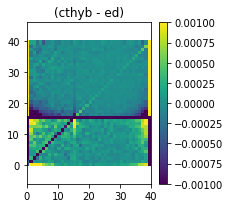

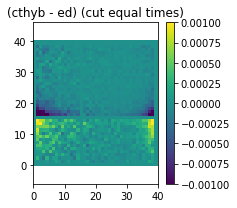

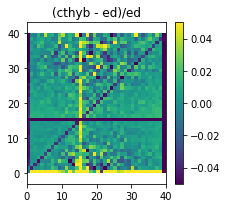

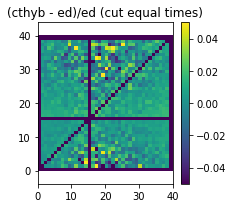

In [103]:
diff = copy.deepcopy(cthyb)
diff.G2_tau.data[:] -= ed.G2_tau.data
diff.G2_tau_cut.data[:] -= ed.G2_tau_cut.data

max_abs_diff = np.max(np.abs(diff.G2_tau_cut.data))
print 'Max(Abs(diff)) =', max_abs_diff
assert( max_abs_diff < 4e-3 )

opt = dict(vmin=-0.001, vmax=0.001)
plot_G2_tau(diff.G2_tau, '(cthyb - ed)', opt=opt)
plot_G2_tau(diff.G2_tau_cut, '(cthyb - ed) (cut equal times)', opt=opt)

diff.G2_tau.data[:] /= ed.G2_tau.data
diff.G2_tau_cut.data[:] /= ed.G2_tau_cut.data

opt = dict(vmin=-0.05, vmax=0.05)
plot_G2_tau(diff.G2_tau, '(cthyb - ed)/ed', opt=opt)
plot_G2_tau(diff.G2_tau_cut, '(cthyb - ed)/ed (cut equal times)', opt=opt)

plt.show()

# Histogram of the error distribution

In the relative error histogram we can directly see the errors from the equal time planes as a separate satellite.

max|diff| = 0.288764371455
max|rel_diff| = 0.922690800976


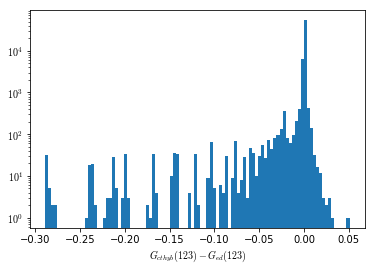

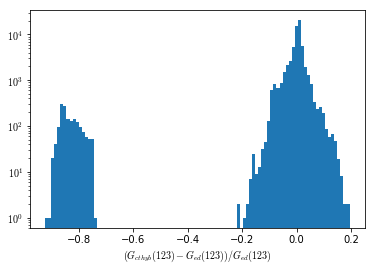

In [104]:
# Get statistics of the errors

def get_diff_and_rel_diff(g1, g2):
    diff = g1.data.real - g2.data.real
    rel_diff = diff / g2.data.real
    diff = diff.flatten()
    rel_diff = rel_diff.flatten()
    return diff, rel_diff

diff, rel_diff = get_diff_and_rel_diff(cthyb.G2_tau, ed.G2_tau)

print 'max|diff| =', np.max(np.abs(diff))
print 'max|rel_diff| =', np.max(np.abs(rel_diff))

plt.hist(diff, bins=100, log=True)
plt.xlabel(r'$G_{cthyb}(123) - G_{ed}(123)$')
plt.show()

plt.hist(rel_diff, bins=100, log=True)
plt.xlabel(r'$(G_{cthyb}(123) - G_{ed}(123))/G_{ed}(123)$')
plt.show()


# Histograms without the equal time plane data

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


max|diff| = 0.00242354832986
max|rel_diff| = 0.149634795323


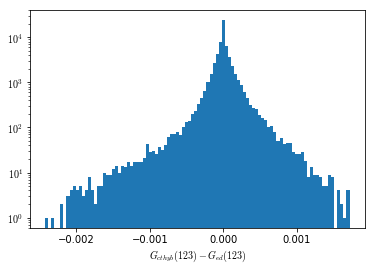

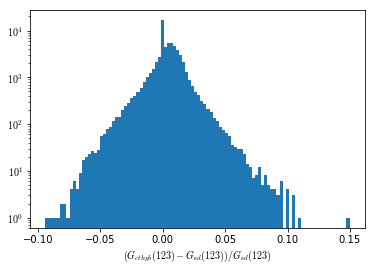

In [105]:
diff, rel_diff = get_diff_and_rel_diff(cthyb.G2_tau_cut, ed.G2_tau_cut)

rel_diff = np.nan_to_num(rel_diff)

max_abs_diff = np.max(np.abs(diff))
print 'max|diff| =', max_abs_diff
assert( max_abs_diff < 4e-3 )

max_abs_rel_diff = np.max(np.abs(rel_diff))
print 'max|rel_diff| =', max_abs_rel_diff
assert( max_abs_rel_diff < 0.20 )

plt.hist(diff, bins=100, log=True)
plt.xlabel(r'$G_{cthyb}(123) - G_{ed}(123)$')
plt.show()

plt.hist(rel_diff, bins=100, log=True)
plt.xlabel(r'$(G_{cthyb}(123) - G_{ed}(123))/G_{ed}(123)$')
plt.show()
